In [1]:
from custom_clss_and_fncs import * 

/DeepenData/.miniconda/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch

PYG_graph_only_CONCEN = torch.load("./results/graphs_from_PYG_and_NX/PYG_graph_only_CONCEN.pt")

    
def make_graphs_list(pyg_graph_in,mask_target:bool=False, target_node:int = 0, mask_number = 0):
    
    pyg_graph = copy.deepcopy(pyg_graph_in)
    graphs_list = []
    
    
    for i in range(pyg_graph.x.shape[1]):
    
        
        new_pyg_data  = Data(x =  pyg_graph.x[:,i].reshape(pyg_graph.num_nodes, 1),  y = pyg_graph.y[i], 
                            edge_index = pyg_graph.edge_index)
        new_pyg_data.num_classes = int(2)
        if mask_target:
            new_pyg_data.x[target_node,:] = mask_number        
        
        graphs_list.append(new_pyg_data) 
    return graphs_list
   


In [4]:
lista_de_grafos =  make_graphs_list(PYG_graph_only_CONCEN)
   
   
    
from torch.utils.data import RandomSampler

def make_loader(graphs: list, batch_size: int  =1*32, num_samples = 500):#batch_size: int  =8*32):

    sampler_train_set = RandomSampler(
        graphs,
        #num_samples= num_samples, #params["training"]["sampler_num_samples"],  # Genera un muestreo del grafo
        replacement=True,  # con repeticion de muestras
    )
    return DataLoader(graphs, batch_size=batch_size, sampler = sampler_train_set,  drop_last=True)


loader   = make_loader(lista_de_grafos)

In [8]:
torch.save(loader, "./results/dataloaders/loader_onlyC.pt")


In [7]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GIN
from torch_geometric.nn import global_mean_pool
gc.collect()
torch.cuda.empty_cache()

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        
        self.GIN_layers =  GIN(in_channels= 1, hidden_channels= hidden_channels, num_layers= 4, 
                               out_channels= hidden_channels, dropout=0.1,  jk=None, 
                               act='LeakyReLU', act_first = True)   
        
        #self.conv1 = GCNConv(1, hidden_channels)
        #self.conv2 = GCNConv(hidden_channels, hidden_channels)
        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2, bias=True)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        #x = self.conv1(x, edge_index)
        #x = x.relu()
        x = self.GIN_layers(x, edge_index)
        #x = F.dropout(x, p=0.1)
        x = x.relu()
        #x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        
        x = self.lin(x)
        
        return F.log_softmax(x, dim=1) #x
    
model    = GCN(hidden_channels=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()
def train():
    model.to('cuda')
    model.train()

    for data in loader:  # Iterate in batches over the training dataset.
         data.to('cuda')
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     model.to('cuda')
     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data.to('cuda')
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 10):
    train()
    train_acc = test(loader)
    test_acc = test(loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.9575, Test Acc: 0.9625


KeyboardInterrupt: 

In [2]:
NX_fluxes_and_concentrations = nx.read_gpickle("./results/graphs_from_PYG_and_NX/NX_fluxes_and_concentrations.gpickle")
NX_only_concentrations       = nx.read_gpickle("./results/graphs_from_PYG_and_NX/NX_only_concentrations.gpickle")
pyg_graph_FplusC      = from_networkx(copy.deepcopy(nx.Graph(NX_fluxes_and_concentrations)))
pyg_graph_onlyC       = from_networkx(copy.deepcopy(nx.Graph(NX_only_concentrations)))
assert not pyg_graph_FplusC.is_directed()
assert not pyg_graph_onlyC.has_isolated_nodes()

In [3]:
oversampled_metabolite_data         = pd.read_parquet("./results/data/oversampled_augmented_metabolite_data.parquet.gzip")#
labels                              = torch.tensor(oversampled_metabolite_data.label).reshape(len(oversampled_metabolite_data.label),1)
assert set(labels.unique().numpy()) == set((1,0))

In [3]:
from torch_geometric.data import Data
from torch.utils.data import RandomSampler

def make_graphs_list(pyg_graph_in,labels,mask_target:bool=False, target_node:int = 0, mask_number = 0):
    
    pyg_graph = copy.deepcopy(pyg_graph_in)
    pyg_graph.y = labels
    graphs_list = []
    
    
    for i in range(pyg_graph.x.shape[1]):
    
        
        new_pyg_data  = Data(x =  pyg_graph.x[:,i].reshape(pyg_graph.num_nodes, 1),  y = pyg_graph.y[i], 
                            edge_index = pyg_graph.edge_index)
        new_pyg_data.num_classes = 2
        if mask_target:
            new_pyg_data.x[target_node,:] = mask_number

            
        
        graphs_list.append(new_pyg_data) 
    return graphs_list



def make_loader(graphs: list, batch_size: int  =4*32, num_samples = 500):

    sampler_train_set = RandomSampler(
        graphs,
        num_samples= num_samples, #params["training"]["sampler_num_samples"],  # Genera un muestreo del grafo
        replacement=True,  # con repeticion de muestras
    )
    return DataLoader(graphs, batch_size=batch_size, sampler = sampler_train_set,  drop_last=True)

graphs_list_only_concentrations       = make_graphs_list(pyg_graph_onlyC,labels)
graphs_list_fluxes_and_concentrations = make_graphs_list(pyg_graph_FplusC,labels)


loader_onlyC  = make_loader(graphs_list_only_concentrations)
loader_FplusC = make_loader(graphs_list_fluxes_and_concentrations)


NameError: name 'pyg_graph_onlyC' is not defined

In [5]:
loader_onlyC

In [6]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GIN
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        
        self.GIN_layers =  GIN(in_channels= 1, hidden_channels= hidden_channels, num_layers= 4, 
                               out_channels= hidden_channels, dropout=0.1,  jk=None, 
                               act='LeakyReLU', act_first = True)   
        
        #self.conv1 = GCNConv(1, hidden_channels)
        #self.conv2 = GCNConv(hidden_channels, hidden_channels)
        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2, bias=True)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        #x = self.conv1(x, edge_index)
        #x = x.relu()
        x = self.GIN_layers(x, edge_index)
        #x = F.dropout(x, p=0.1)
        x = x.relu()
        #x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        
        x = self.lin(x)
        
        return F.log_softmax(x, dim=1) #x
    
model    = GCN(hidden_channels=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()
loader = loader_onlyC
def train():
    model.to('cuda')
    model.train()

    for data in loader:  # Iterate in batches over the training dataset.
         data.to('cuda')
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     model.to('cuda')
     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data.to('cuda')
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 10):
    train()
    train_acc = test(loader)
    test_acc = test(loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.0226, Test Acc: 0.0283
Epoch: 002, Train Acc: 0.0298, Test Acc: 0.0305
Epoch: 003, Train Acc: 0.0475, Test Acc: 0.0460
Epoch: 004, Train Acc: 0.0415, Test Acc: 0.0429
Epoch: 005, Train Acc: 0.0452, Test Acc: 0.0433
Epoch: 006, Train Acc: 0.0310, Test Acc: 0.0313
Epoch: 007, Train Acc: 0.0283, Test Acc: 0.0265
Epoch: 008, Train Acc: 0.0461, Test Acc: 0.0479
Epoch: 009, Train Acc: 0.0482, Test Acc: 0.0468


In [ ]:
def plot_classsifiers(X, y):
    

    #clf1 = LogisticRegression()
    #clf2 = DecisionTreeClassifier()
    clf3 = RandomForestClassifier()
    clf4 = SVC(gamma='auto')
    clf5 = GaussianNB()
    clf6 = MLPClassifier()

    gs = gridspec.GridSpec(3, 2)
    fig = plt.figure(figsize=(14,7))
    labels = ['Random Forest', 'SVM', 'Naive Bayes', 'Neural Network']
    for clf, lab, grd in zip([clf3, clf4, clf5, clf6],
                            labels,
                            [(0,0), (0,1), (1,0), (1,1)]):
        clf.fit(X, y)
        ax = plt.subplot(gs[grd[0], grd[1]])
        fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
        plt.title(lab)
    plt.show()
    
    
    
def train_classifiers_with_dataloader(loader):   
    
    contatenated = torch.Tensor()
    labels_from_loader       = torch.Tensor()

    for data in loader:  # Iterate in batches over the training dataset.
            #data.to('cuda')
            #out = model(data.x, data.edge_index, data.batch)
            reshaped_batch     = data.x.reshape(data.y.shape[0], -1)
            contatenated       = torch.cat((contatenated,reshaped_batch),0)        
            labels_from_loader = torch.cat((labels_from_loader, data.y),0)
            

    non_zero_cols =  np.sum(contatenated.numpy() , 0) !=0
    X_from_loader = contatenated[:,non_zero_cols]

    reducer = umap.UMAP()
    embedding = reducer.fit_transform(X_from_loader)
    plot_classsifiers(embedding, labels_from_loader.to(int).numpy())
    plt.show()

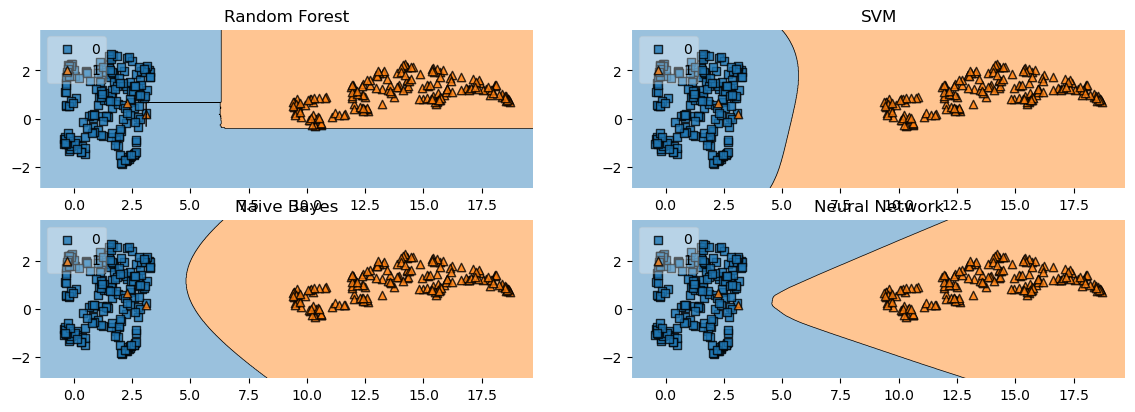

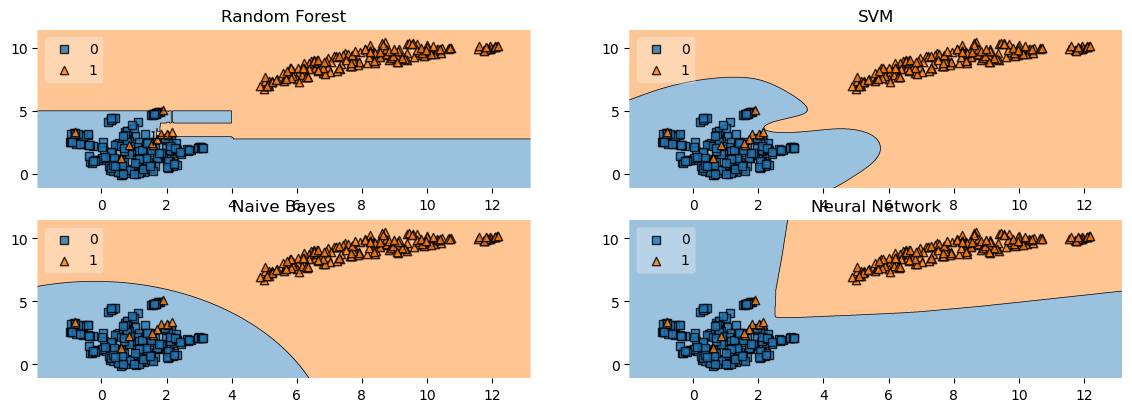

In [ ]:
train_classifiers_with_dataloader(loader_onlyC)
train_classifiers_with_dataloader(loader_FplusC)

In [ ]:


target_node = "phe_L_c"
assert list(NX_only_concentrations.nodes).index(target_node) == list(NX_fluxes_and_concentrations.nodes).index(target_node)
phe_L_c_idx = list(NX_only_concentrations.nodes).index(target_node)


graphs_list_only_concentrations_MASKED       = make_graphs_list(pyg_graph_onlyC,labels, mask_target = True, target_node = phe_L_c_idx)
graphs_list_fluxes_and_concentrations_MASKED = make_graphs_list(pyg_graph_FplusC,labels, mask_target = True, target_node = phe_L_c_idx)


loader_onlyC_MASKED  = make_loader(graphs_list_only_concentrations_MASKED)
loader_FplusC_MASKED = make_loader(graphs_list_fluxes_and_concentrations_MASKED)


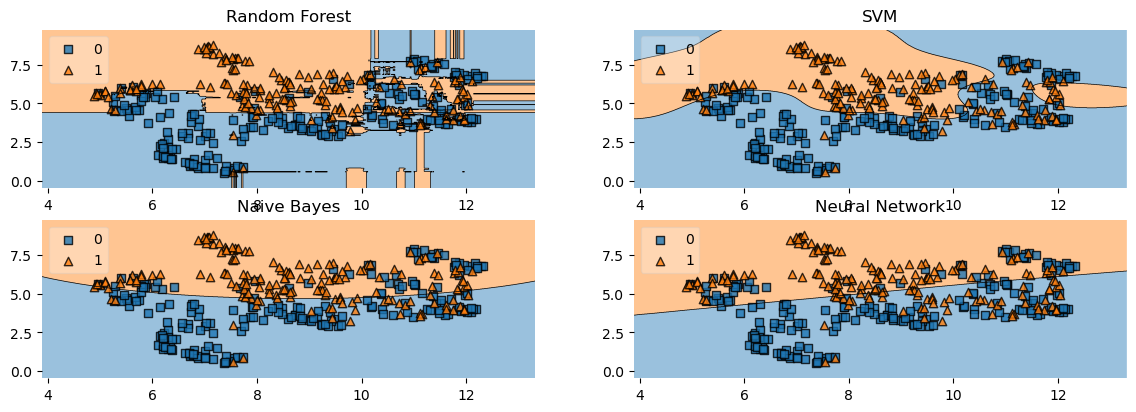

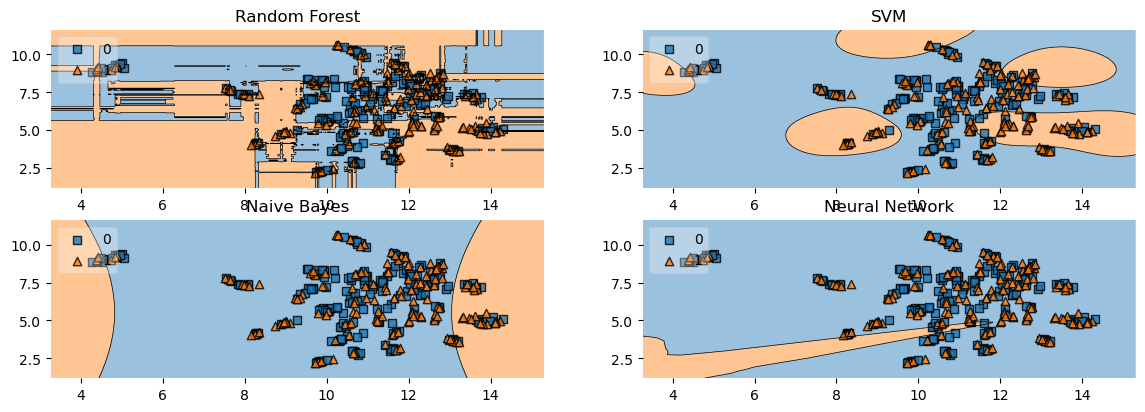

In [ ]:
train_classifiers_with_dataloader(loader_onlyC_MASKED)
train_classifiers_with_dataloader(loader_FplusC_MASKED)

In [ ]:
torch.save(loader_onlyC, "./results/dataloaders/loader_onlyC.pt")
torch.save(loader_FplusC, "./results/dataloaders/loader_FplusC.pt")
torch.save(loader_onlyC_MASKED, "./results/dataloaders/loader_onlyC_MASKED.pt")
torch.save(loader_FplusC_MASKED, "./results/dataloaders/loader_FplusC_MASKED.pt")